In [2]:
# ! pip install yfinance
# ! pip install pandas_datareader

In [3]:
import bs4 as bs
import requests
import yfinance as yf
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [8]:
tickers=["AIV","AMZN","CL","EW"]

In [9]:
start = datetime.datetime(2010,1,1)
end = datetime.datetime(2019,7,17)
data = yf.download(tickers, start=start, end=end)

[*********************100%***********************]  4 of 4 completed


In [10]:
data.head()

Adj Close                         ...    Volume                  
                  AIV        AMZN         CL  ...      AMZN       CL       EW
Date                                          ...                            
2010-01-04  11.140982  133.899994  29.419109  ...   7599900  4874200  3092400
2010-01-05  11.420205  134.690002  29.657007  ...   8851900  5296800  2787600
2010-01-06  11.622641  132.250000  29.589546  ...   7178800  7195200  3009600
2010-01-07  12.048461  130.000000  29.472368  ...  11030200  3752200  2702400
2010-01-08  11.769234  133.520004  28.943281  ...   9830500  8150200  3574800

[5 rows x 24 columns]

In [11]:
df=pd.DataFrame(data["Adj Close"])
df.head()

,AIV,AMZN,CL,EW
Date,,,,
2010-01-04,11.140982,133.899994,29.419109,7.289166
2010-01-05,11.420205,134.690002,29.657007,7.341667
2010-01-06,11.622641,132.250000,29.589546,7.422500
2010-01-07,12.048461,130.000000,29.472368,7.490000
2010-01-08,11.769234,133.520004,28.943281,7.456666


In [12]:
returns = df.pct_change()
mean_return = returns.mean()
return_stdev = returns.std()

annualised_return = round(mean_return * 252, 4)
annualised_stdev = round(return_stdev * np.sqrt(252), 4)

In [13]:
#calculate mean daily return and covariance of daily returns
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()

In [14]:
#set number of runs of random portfolio weights
num_portfolios = 50000

In [15]:
#set up array to hold results

results = np.zeros(((4+df.shape[1]-1),num_portfolios))

In [16]:
for i in range(num_portfolios):
    #select random weights for portfolio holdings
    weights = np.array(np.random.random(df.shape[1]))
    #rebalance weights to sum to 1
    weights /= np.sum(weights)
    #calculate portfolio return and volatility
    portfolio_return = np.sum(mean_daily_returns * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    #store results in results array
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    #store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
    results[2,i] = results[0,i] / results[1,i]
    #iterate through the weight vector and add data to results array
    for j in range(len(weights)):
        results[j+3,i] = weights[j]

In [17]:
#convert results array to Pandas DataFrame
column_names=list(['ret','stdev','sharpe']) + list(df.columns)
results_frame = pd.DataFrame(results.T, columns=column_names)

In [18]:
results_frame["sanity_check"]=results_frame.iloc[:,3:].sum(axis=1)
results_frame.head()

,ret,stdev,sharpe,AIV,AMZN,CL,EW,sanity_check
0,0.235031,0.183444,1.281212,0.188283,0.247977,0.223706,0.340034,1.0
1,0.205971,0.164692,1.250646,0.318174,0.198888,0.309624,0.173315,1.0
2,0.221166,0.176459,1.253357,0.097263,0.220206,0.346269,0.336262,1.0
3,0.283827,0.230512,1.231288,0.105277,0.357025,0.015460,0.522237,1.0
4,0.198446,0.189703,1.046085,0.006216,0.041121,0.468264,0.484399,1.0


In [19]:
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]

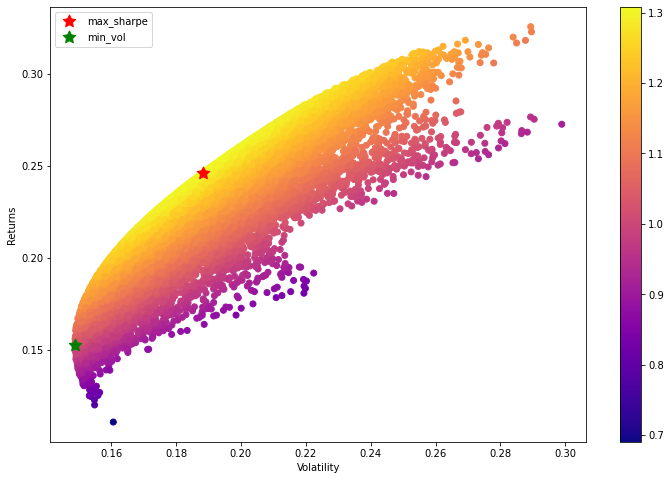

In [20]:
#create scatter plot coloured by Sharpe Ratio
plt.figure(figsize=(12,8))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='plasma')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r', s=170, label="max_sharpe")
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=170, label="min_vol")
plt.legend()